In [219]:
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import numpy as np
import numpy.linalg as l
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math  
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
import matplotlib
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize._lsq.least_squares import arctan
matplotlib.rcParams.update({'font.size': 8})


# Initialisation

In [220]:
#Rayon de la sphere
p_a = 11
#Norme max de u (à changer)
u_max = 0.05
# accélération max 
a_max = u_max
#Point de départ
r0 = np.array([12.0,8.0,0.0])
v0 = np.array([0,0,0])
x0 = np.array([r0,v0]).reshape(-1)
#Constantes pour la fonction V
k1 = 0.5
k2 = 0.1
k3 = 0.05
J = 10

tf = 10


# Fonctions


In [221]:
#Pour afficher une barre de progression (cosmétique)
def progress(i, n):
    i += 1
    k = int(i/n*20)
    print(f'\rProgression:[{k*"#"}{(20-k)*" "}] [{(i/n*100):.0f} %]',
          end='' if i != n else "\n", flush=True)
      
def h(x):
    r = np.array(x[:3])
    res = p_a - l.norm(r)
    return res  

f  = lambda x : np.array([x[3],x[4],x[5],0,0,0])
g = np.zeros((6,3))
g[3:6,:] = np.eye(3)

def h_dot(x):
    r = x[:3]
    v = x[3:]
    return - r@v / l.norm(r)

def h_ddot(x, u) :
    r = x[:3]
    v = x[3:]
    return (- l.norm(np.cross(r, v)**2) / l.norm(r)**3) - r@u / l.norm(r)

#Dynamique avec le u*
def dynamic_int(t,x) : 
    r = x[:3]
    v = x[3:]
    r_dot = v
    v_dot =  a_max * r / l.norm(r)
    return np.array([r_dot,v_dot]).reshape(-1)

#Pour arreter l'intégration au max
def event(t,x) :
    return h_dot(x)
            

event.terminal = True

# H = psi_x, renvoie le point le plus proche de la sphère
def H_x(x): 
    #On intègre pour un t assez grand et on s'arrete quand la dérivée de h est nulle
    res = solve_ivp(dynamic_int,(0,20),x,max_step=0.1,events=event)
    #Le dernier point et le temps d'arrret 
    return res.y.T[-1], res.t_events[0]

#H = psi_h
H_h = lambda x : h(H_x(x)[0])

  
def cost_func(params) : 
    u = params[:3]
    d = params[-1]
    return u@u + J * d**2 + 100*max(l.norm(u)-u_max,0)



# TEST V


In [222]:
def r_p(t) : 
    phi  = -np.pi/12
    theta_dot = 0.5 * np.pi / tf
    theta = np.pi/4 + 3*theta_dot * t
    r_g = 10 
    res1 = r_g * np.array([np.cos(phi)*np.cos(theta), np.cos(phi)*np.sin(theta), np.sin(phi)])
    res2 = r_g * theta_dot * np.array([- np.cos(phi)*np.sin(theta), np.cos(phi)*np.cos(theta), 0])
    return res1,res2

def V(x,t) : 
    r = x[:3]
    v = x[3:] 
    b = r - r_p(t)[0]
    a = v - k1 * b
    res = b@b / 2 + k2 / 2 * a@a
    return res
    
def V_p(x,t) : 
    rp = r_p(t)[0]
    r = x[:3]
    v = x[3:]
    dVdr = r - rp - k2*k1 * (v - k1 * (r - rp))
    dVdv = k2 * (v - k1 * (r - rp))
    return np.array([dVdr, dVdv]).reshape(-1)

def L_fV(x,t) : 
    return np.dot(V_p(x,t),f(x))

def L_gV(x,t) : 
    return np.dot(V_p(x,t),g)
    
def dVrp(x, t):
    rp,rp_dot = r_p(t)

    r = x[:3]
    v = x[3:]
    dVdp = - (r - rp) + k2*k1 * (v - k1 * (r - rp))
    return dVdp@rp_dot

    
print(V_p(x0,15))


[12.3        -1.70073972  2.65289521 -0.6         0.08296291 -0.12940952]


# Calcul de H_dot 
En prenant exemple sur le papier


In [223]:
def matA(x) : 
    res = np.zeros((6,6))
    res[0:3,3:] = np.eye(3)
    r = x[:3]
    n = l.norm(r)
    res[3:,0:3] = np.eye(3) / n - r.reshape(3, 1)@r.reshape(1, 3)/ n**3 
    return res

def dyn_test(t,x) : 
    z = x[0:6]
    theta = x[6:].reshape((6,6))
    z_dot = dynamic_int(t,z)
    B = matA(z)
    theta_dot = B@theta
    x_dot = np.zeros(42)
    x_dot[0:6] = z_dot
    x_dot[6:] = theta_dot.reshape(-1)
    return x_dot

def grad_H(x) : 
    x_c, t_c = H_x(x)
    y0 = np.zeros((42))
    y0[0:6]=x
    y0[6:] = np.eye((6)).reshape(-1)
    if ((len(t_c)==0) or t_c[0] == 0) : 
        res = y0
        z_val = res[0:6]
        theta = res[6:].reshape((6,6))
    else : 
        res = solve_ivp(dyn_test,(0.0,t_c),y0)
        z_val = res.y.T[-1][0:6]
        theta = res.y.T[-1][6:].reshape((6,6))

    r  = x_c[:3]
    hp = np.zeros(6)
    hp[:3] = -r/l.norm(r)
    dH = hp@theta
    return dH, dH@f(x), dH@g

# print(grad_H(x0))
print(H_x(x0))

(array([12.,  8.,  0.,  0.,  0.,  0.]), array([0.]))


# graphe H

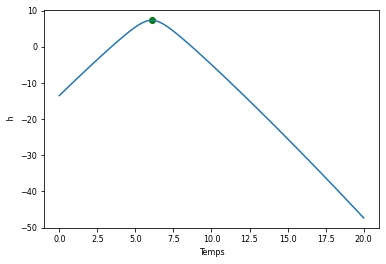

In [224]:
r1 = np.array([20.0,10.0,10.0])
v1 = np.array([-3,-2,-2])
x1 = np.array([r1,v1]).reshape(-1)

res = solve_ivp(dynamic_int,[0,20],x1,max_step=0.1)
x_c ,t_c = H_x(x1)
h_x =  [h(a) for a in res.y.T]
plt.plot(np.linspace(0,20,201),h_x)
plt.scatter(t_c,h(x_c),color="g")
plt.xlabel("Temps")
plt.ylabel(" h")
plt.show()

# Fonction animation + plot

In [225]:
def main(s,x0,name) : 
    sol = s
    sol_l = sol.tolist()
    sol_l.sort(key=h)

    def init():
        ax.set(xlim=(-15,15),ylim=(-15,15),zlim=(-10,10))
        legend = ax.legend(loc="upper left", shadow = True)
        legend.get_frame().set_facecolor('C0')
        ax.scatter(x0[0],x0[1],x0[2],color="g",label="Point de départ")
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = p_a*np.cos(u)*np.sin(v) 
        y = p_a*np.sin(u)*np.sin(v)
        z = p_a*np.cos(v)
        ax.plot_wireframe(x, y, z, color="gray",label="Obstacle")
        ax.view_init(67,130)
        #ax.set_aspect('equal')
        return lines


    def update_lines(num, data, lines,points):
        for dat,line, point in zip(data,lines,points):
            line.set_data(dat[0:2, :num+1])
            line.set_3d_properties(dat[2, :num+1])
            if((dat[0:2, num][0] == sol_l[-1][0]) and (dat[0:2, num][1] == sol_l[-1][1]) and (dat[2, num] == sol_l[-1][2])):
                ax.scatter(sol_l[-1][0],sol_l[-1][1],sol_l[-1][2],color="b",label="Max")
            point.set_data(dat[0:2, num])
            point.set_3d_properties(dat[2, num])
            
        return lines

    # Attaching 3D axis to the figure
    fig = plt.figure(figsize=(7,7))
    ax = fig.gca(projection='3d')

    X = [e[0] for e in sol]
    Y = [e[1] for e in sol]
    Z = [e[2] for e in sol]
    data = np.array([[X,Y,Z]])

    lines = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1], 'm')[0] for dat in data]
    points = [ax.plot(dat[0, 0:1], dat[1, 0:1], dat[2, 0:1], 'ro')[0] for dat in data]

    line_ani = animation.FuncAnimation(fig, update_lines,len(sol), fargs=(data, lines,points),
                                    interval=10, init_func=init, blit=True, repeat=True)
    writergif = animation.PillowWriter(fps=int(len(sol)/3))
    line_ani.save('test'+name+'.gif',writer=writergif)



def fctplot(sol,rp=False) :

    tablex = []
    tabley = []
    tablez = []
    for i in range(0,len(sol)): 
        tablex.append(sol[i][0]) 
        tabley.append(sol[i][1])
        tablez.append(sol[i][2])
    X = np.array(tablex)
    Y = np.array(tabley)
    Z = np.array(tablez)

    T = np.linspace(0,tf,len(X))
    R_p = [r_p(t)[0] for t in T]
    r_px = [test[0] for test in R_p]
    r_py = [test[1] for test in R_p]
    r_pz = [test[2] for test in R_p]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(X, Y, Z, color="r",label="Trajectoire")
    if rp : 
        ax.plot(r_px,r_py,r_pz, color="b")
    ax.scatter(x0[0],x0[1],x0[2],color="g",label="Point de départ")
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = p_a*np.cos(u)*np.sin(v) 
    y = p_a*np.sin(u)*np.sin(v)
    z = p_a*np.cos(v)
    ax.plot_wireframe(x, y, z, color="gray",label="Obstacle")

    ax.set(xlim=(-15,15),ylim=(-15,15))
    ax.view_init(67,130)
    plt.show()

# Cas $u_{ball}$

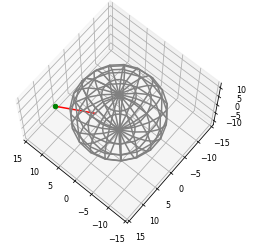

In [226]:
r_test = np.array([12.0,8.0,0.0])
v_test = np.array([-2,-2,-2])
x_test = np.array([r_test,v_test]).reshape(-1)

res = solve_ivp(dynamic_int,[0,20],x_test,max_step=0.5,events=event)
fctplot(res.y.T)
# main(sol,x_test,"_fuite")

# Trajectoire

# Dynamique 2 


In [227]:
#Vecteur initiale pour l'optimiseur delta0 = 1, j'ai pris une valeur arbitraire
def dynamic_int2(t,x):
    # progress(t, tf)
    progress(t, tf)
    r = x[:3]
    v = x[3:]
    a = np.zeros(4)
    dH = grad_H(x)
    a[:3] = dH[2]
    b = np.ones(4)
    b[:3] = -L_gV(x,t)

    A = np.array([a,b])
    c = np.array([dH[1] + H_h(x),L_fV(x,t) +k3*V(x,t) + dVrp(x, t)])
    
    # A = -b
    # c = L_fV(x,t) +k3*V(x,t) + dVrp(x, t)
    
    # cons = ({'type' : 'ineq', 'fun' : lambda u : -l.norm(u[:3]) + u_max })
    linear_cons = LinearConstraint(A,-np.inf*np.ones(2),-c)
    nonlinear_cons = NonlinearConstraint(lambda u : l.norm(u),0, u_max)
    
    res = minimize(cost_func,u0,method ='SLSQP', constraints=(linear_cons,nonlinear_cons))
 
    r_dot = v
    v_dot =  res.x[:3]
    # print("Contrôle pour t = ",t," : ",v_dot)
    return np.array([r_dot,v_dot]).reshape(-1)


In [228]:
u0 = np.array([0,0,0,10])
t= [0,tf]
r0 = r_p(0)[0]   + np.array([3,3,0])
v0 = np.array([0,0,0])
x0 = np.array([r0,v0]).reshape(-1)

res = solve_ivp(dynamic_int2,t,x0)

Progression:[######################] [110 %]

# Plot 

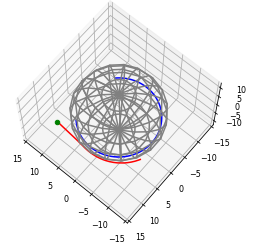

In [229]:
fctplot(res.y.T,True)

In [230]:

# main(res.y.T,x0,"2")

# TESTS contraintes pour x0
Pour l'optimisation en x0

In [231]:
# u = np.array([0,0,0,10])
# a = np.zeros(4)
# dH = grad_H(x0)
# a[:3] = dH[2]
# b = np.ones(4)
# b[:3] = L_gV(x0,0)
# # A = np.array([a,b])
# A = b 
# c = L_fV(x0,0) +k3*V(x0,0) + dVrp(x0, 0)
# # c = np.array([dH[1] + H_h(x0),L_fV(x0,0) +k3*V(x0,0) + dVrp(x0, 0)])
# # cons = ({'type' : 'ineq', 'fun' : lambda u : -l.norm(u[:3]) + u_max })

# linear_cons = LinearConstraint(A,-np.inf*np.ones(1),-c)
# res = minimize(cost_func,u0,method ='SLSQP',constraints=[linear_cons])

# print(res.x)
# print("Contrainte 1 : ",(A@res.x  < -c ))
# print("Contrainte 2 : ",l.norm(res.x[:3]) < u_max)



# Animation 

In [232]:
# a = main(sol,x0,"_traj")